In [23]:
# Data Integration, Correlation Analysis & K-Means Clustering

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Loading all three cleaned datasets
behaviour_path = r"C:\Users\Ahana\Desktop\Customer-Sales-Analysis\data\cleaned_customer_behaviour.csv"
segmentation_path = r"C:\Users\Ahana\Desktop\Customer-Sales-Analysis\data\cleaned_customer_segmentation.csv"
sales_path = r"C:\Users\Ahana\Desktop\Customer-Sales-Analysis\data\cleaned_sales_data.csv"

df_behaviour = pd.read_csv(behaviour_path)
df_segmentation = pd.read_csv(segmentation_path)
df_sales = pd.read_csv(sales_path)

print(f"Customer Behaviour: {df_behaviour.shape[0]} rows × {df_behaviour.shape[1]} columns")
print(f"Customer Segmentation: {df_segmentation.shape[0]} rows × {df_segmentation.shape[1]} columns")
print(f"Sales Data: {df_sales.shape[0]} rows × {df_sales.shape[1]} columns")

Customer Behaviour: 1000 rows × 28 columns
Customer Segmentation: 1000 rows × 9 columns
Sales Data: 100000 rows × 9 columns


In [24]:
# Identifying common features

print("\nCustomer Behaviour Columns:")
print(df_behaviour.columns.tolist())

print("\nCustomer Segmentation Columns:")
print(df_segmentation.columns.tolist())

print("\nSales Data Columns:")
print(df_sales.columns.tolist())

# Identify common demographic features
common_features = {
    'age': ['Age', 'age', 'Customer_Age'],
    'gender': ['Gender', 'gender', 'Customer_Gender'],
    'purchase_amount': ['Purchase_Amount', 'last_purchase_amount', 'Sales_Amount'],
    'category': ['Purchase_Category', 'preferred_category', 'Product_Category']
}

print("\n" + "-" * 100)
print("Common Feature Mapping:")
print("-" * 100)
for feature, cols in common_features.items():
    print(f"{feature}: {cols}")

# Creating unified dataset for analysis

# Aggregating sales data by customer demographics
print("\nAggregating sales data...")
sales_agg = df_sales.groupby(['Customer_Age', 'Customer_Gender']).agg({
    'Sales_Amount': ['mean', 'sum', 'count'],
    'Discount': ['mean', 'sum']
}).reset_index()

sales_agg.columns = ['Age', 'Gender', 'Avg_Sale', 'Total_Sales', 'Purchase_Count', 'Avg_Discount', 'Total_Discount']

print(f"Sales data aggregated: {sales_agg.shape[0]} unique customer profiles")

# Create analysis dataset combining key metrics from all sources
# Using segmentation as the base, it has customer-level data
analysis_df = df_segmentation.copy()

# Renaming columns for consistency
analysis_df = analysis_df.rename(columns={
    'age': 'Age',
    'gender': 'Gender',
    'income': 'Income',
    'spending_score': 'Spending_Score',
    'membership_years': 'Membership_Years',
    'purchase_frequency': 'Purchase_Frequency',
    'preferred_category': 'Preferred_Category',
    'last_purchase_amount': 'Last_Purchase_Amount'
})

print(f"Unified dataset created: {analysis_df.shape[0]} rows × {analysis_df.shape[1]} columns")


Customer Behaviour Columns:
['Customer_ID', 'Age', 'Gender', 'Income_Level', 'Marital_Status', 'Education_Level', 'Occupation', 'Location', 'Purchase_Category', 'Purchase_Amount', 'Frequency_of_Purchase', 'Purchase_Channel', 'Brand_Loyalty', 'Product_Rating', 'Time_Spent_on_Product_Research(hours)', 'Social_Media_Influence', 'Discount_Sensitivity', 'Return_Rate', 'Customer_Satisfaction', 'Engagement_with_Ads', 'Device_Used_for_Shopping', 'Payment_Method', 'Time_of_Purchase', 'Discount_Used', 'Customer_Loyalty_Program_Member', 'Purchase_Intent', 'Shipping_Preference', 'Time_to_Decision']

Customer Segmentation Columns:
['id', 'age', 'gender', 'income', 'spending_score', 'membership_years', 'purchase_frequency', 'preferred_category', 'last_purchase_amount']

Sales Data Columns:
['Sales_ID', 'Product_Category', 'Sales_Amount', 'Discount', 'Sales_Region', 'Date_of_Sale', 'Customer_Age', 'Customer_Gender', 'Sales_Representative']

-----------------------------------------------------------

In [25]:
# Feature engineering for clustering 

# Select numerical features for clustering
numerical_features = ['Age', 'Income', 'Spending_Score', 'Membership_Years', 
                      'Purchase_Frequency', 'Last_Purchase_Amount']

# Create additional features
analysis_df['Purchase_per_Year'] = analysis_df['Purchase_Frequency'] / (analysis_df['Membership_Years'] + 1)
analysis_df['Spending_per_Purchase'] = analysis_df['Last_Purchase_Amount'] / (analysis_df['Purchase_Frequency'] + 1)
analysis_df['Income_to_Spending_Ratio'] = analysis_df['Income'] / (analysis_df['Last_Purchase_Amount'] + 1)

# Add engineered features
numerical_features.extend(['Purchase_per_Year', 'Spending_per_Purchase', 'Income_to_Spending_Ratio'])

print(f"Features for clustering: {len(numerical_features)}")
for i, feature in enumerate(numerical_features, 1):
    print(f"  {i}. {feature}")

Features for clustering: 9
  1. Age
  2. Income
  3. Spending_Score
  4. Membership_Years
  5. Purchase_Frequency
  6. Last_Purchase_Amount
  7. Purchase_per_Year
  8. Spending_per_Purchase
  9. Income_to_Spending_Ratio


Comprehensive Correlation Analysis - Strongest Correlators vs Weakest Correlators
Strongest Correlations

Top 10 Strongest Correlations:
----------------------------------------------------------------------------------------------------


,Feature 1,Feature 2,Correlation
27,Purchase_Frequency,Purchase_per_Year,0.605292
23,Membership_Years,Purchase_per_Year,-0.588124
28,Purchase_Frequency,Spending_per_Purchase,-0.536594
32,Last_Purchase_Amount,Income_to_Spending_Ratio,-0.501934
31,Last_Purchase_Amount,Spending_per_Purchase,0.383699
33,Purchase_per_Year,Spending_per_Purchase,-0.326371
14,Income,Income_to_Spending_Ratio,0.208047
35,Spending_per_Purchase,Income_to_Spending_Ratio,-0.195998
21,Membership_Years,Purchase_Frequency,0.069532
13,Income,Spending_per_Purchase,-0.062660


Weakest Correlations

Top 10 Weakest Correlations (Closest to Zero):
----------------------------------------------------------------------------------------------------


,Feature 1,Feature 2,Correlation
34,Purchase_per_Year,Income_to_Spending_Ratio,-0.010049
7,Age,Income_to_Spending_Ratio,0.008963
29,Purchase_Frequency,Income_to_Spending_Ratio,-0.008922
16,Spending_Score,Purchase_Frequency,0.006708
25,Membership_Years,Income_to_Spending_Ratio,0.006705
5,Age,Purchase_per_Year,-0.006676
2,Age,Membership_Years,-0.003431
0,Age,Income,-0.000688
10,Income,Purchase_Frequency,0.000533
8,Income,Spending_Score,0.000020



Near-Zero Correlations (|r| < 0.1) - Potentially Independent Features:
----------------------------------------------------------------------------------------------------


,Feature 1,Feature 2,Correlation
8,Income,Spending_Score,0.000020
10,Income,Purchase_Frequency,0.000533
0,Age,Income,-0.000688
2,Age,Membership_Years,-0.003431
5,Age,Purchase_per_Year,-0.006676
25,Membership_Years,Income_to_Spending_Ratio,0.006705
16,Spending_Score,Purchase_Frequency,0.006708
29,Purchase_Frequency,Income_to_Spending_Ratio,-0.008922
7,Age,Income_to_Spending_Ratio,0.008963
34,Purchase_per_Year,Income_to_Spending_Ratio,-0.010049


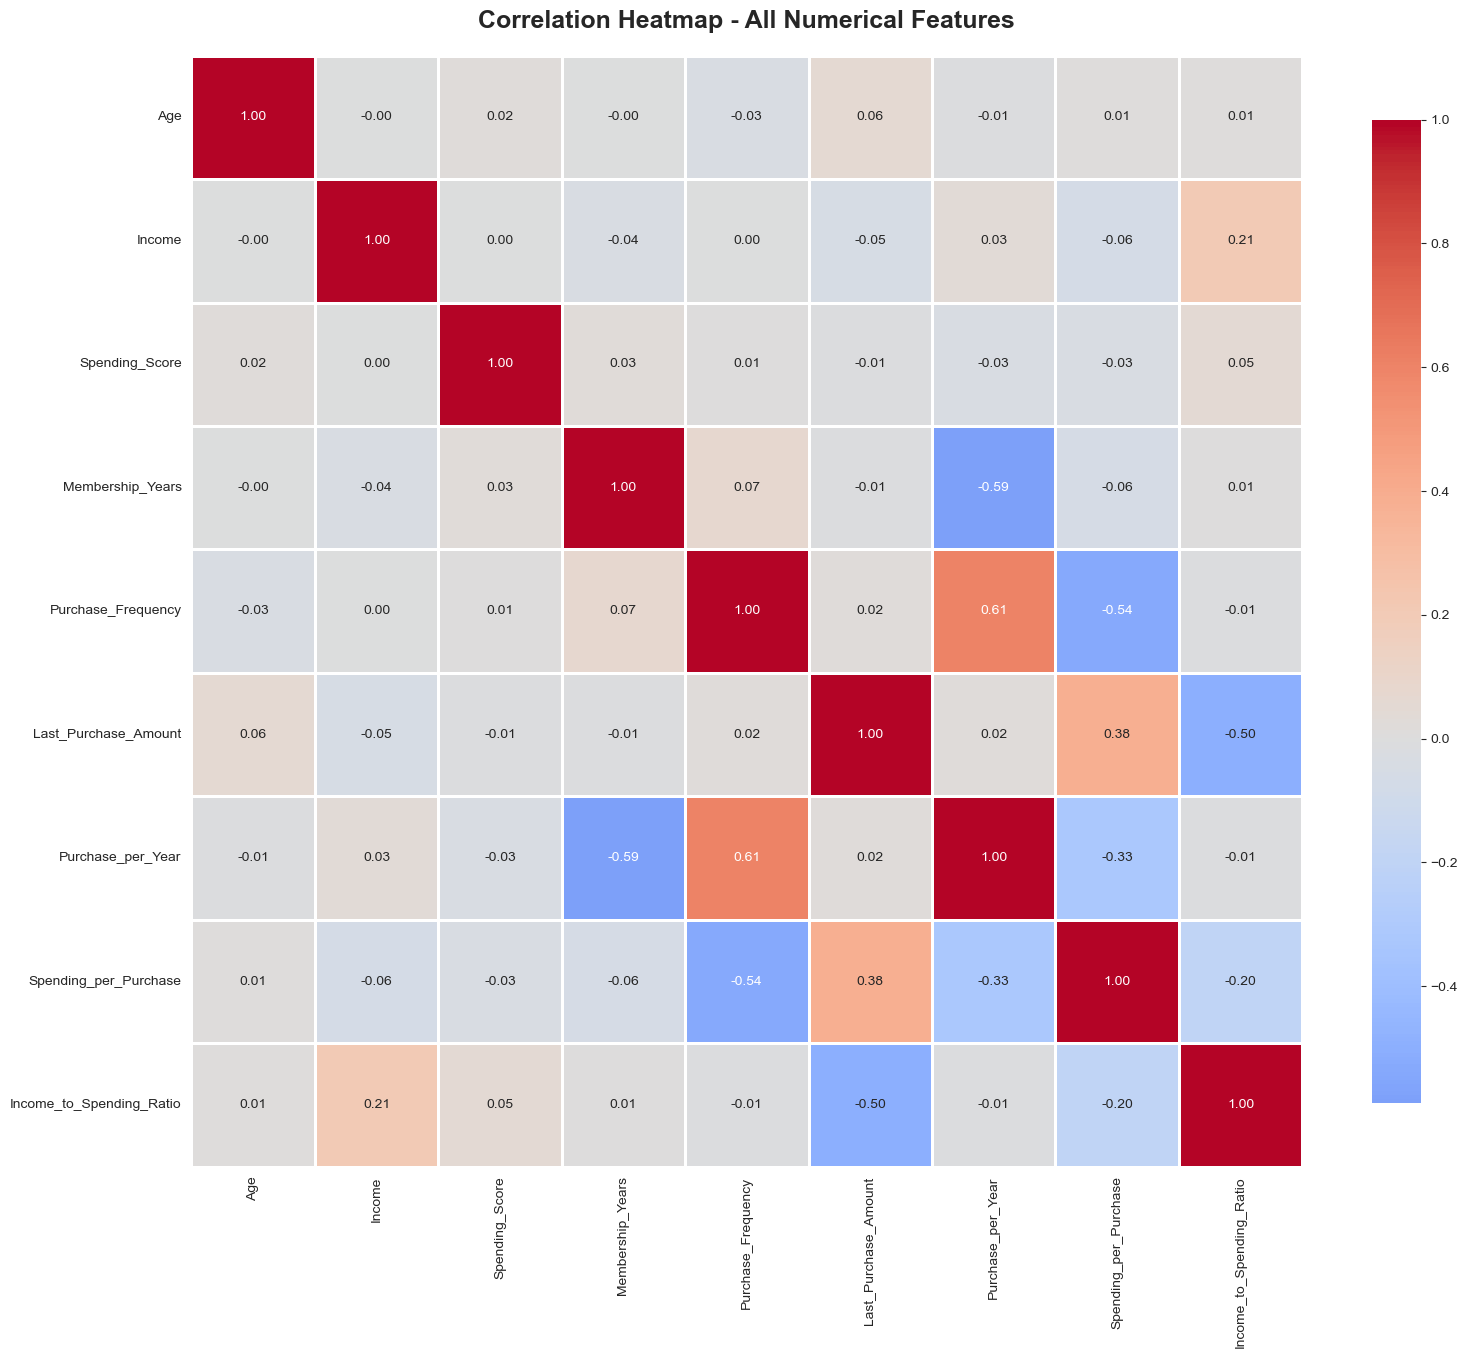

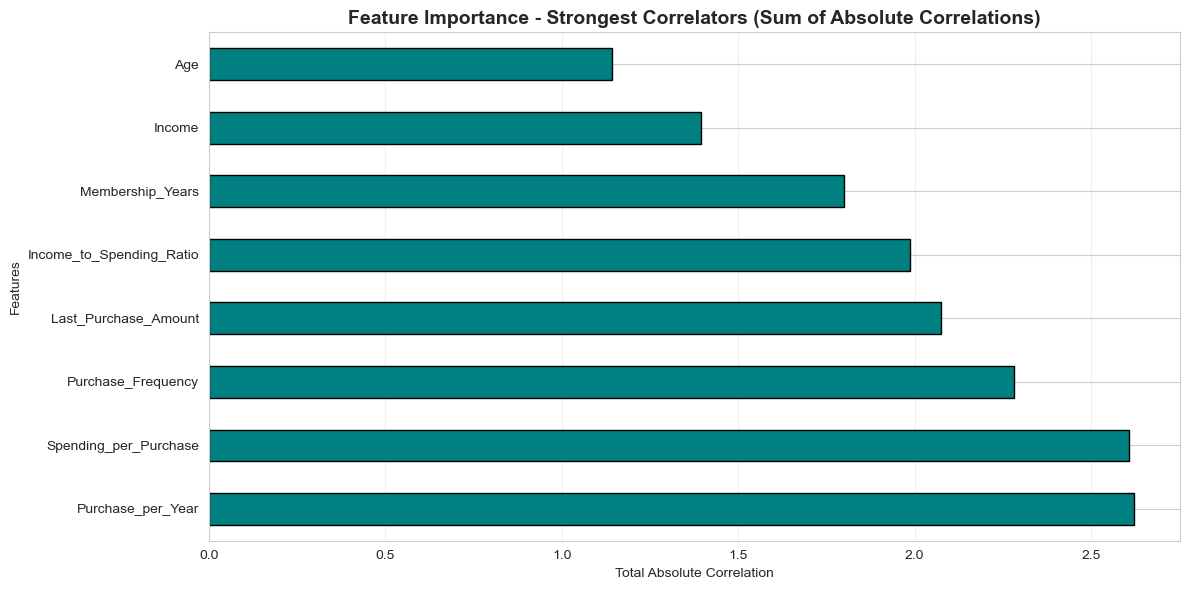

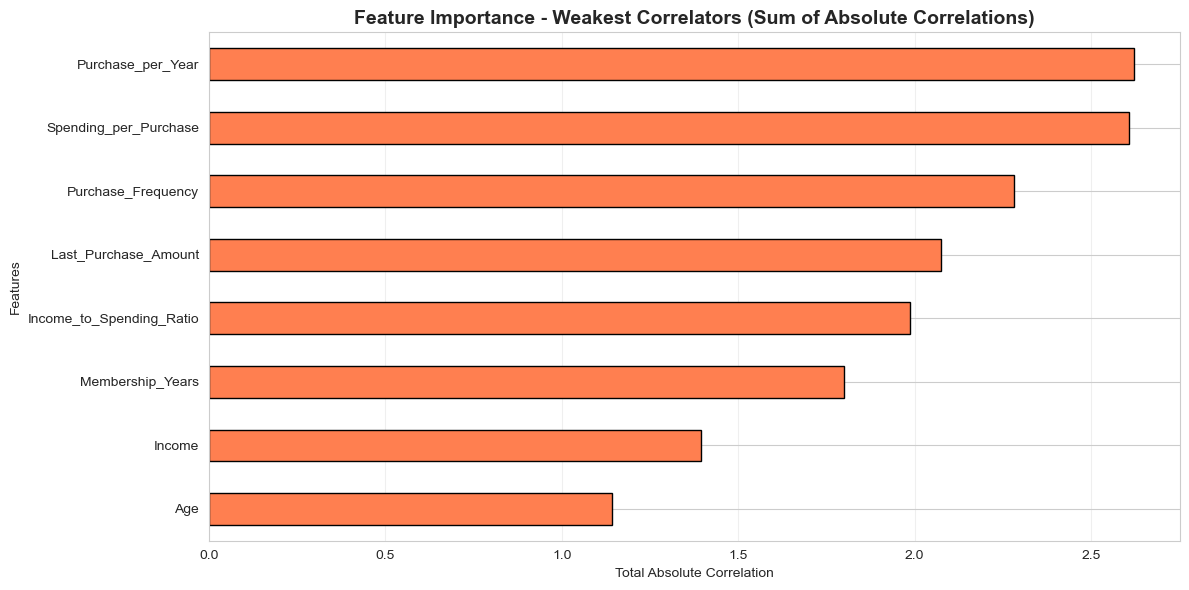

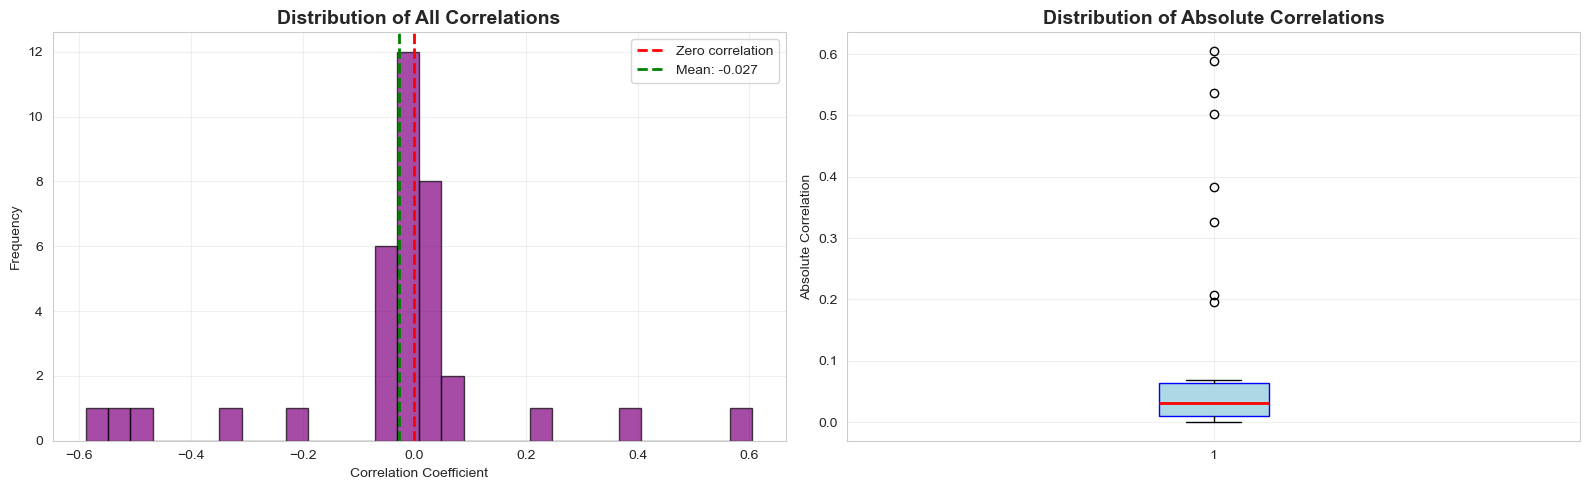

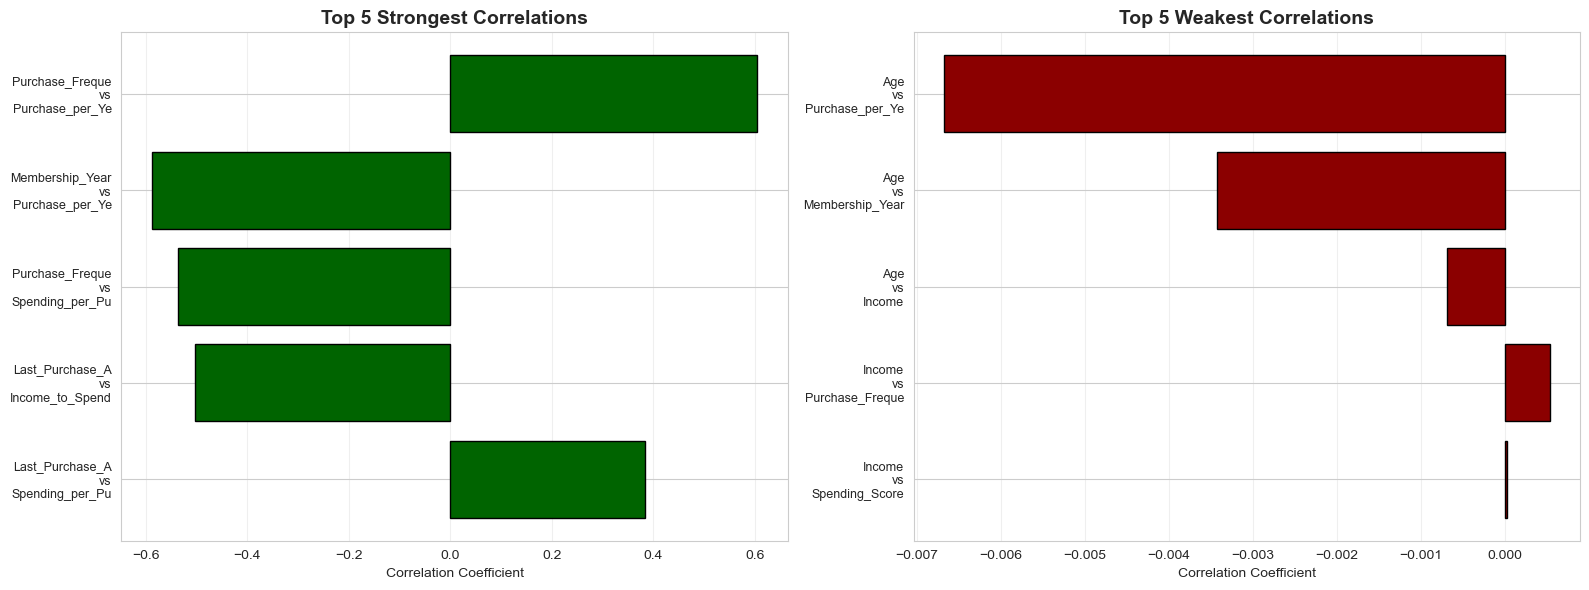

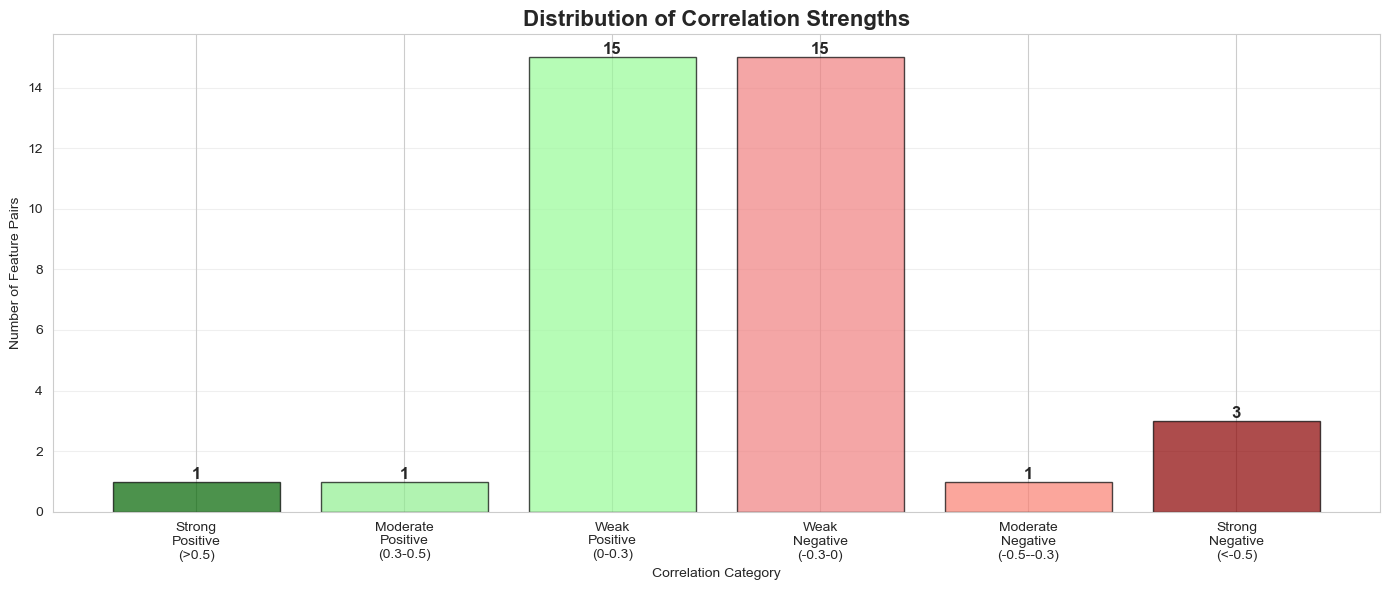


Correlation Analysis Summary:
----------------------------
Total Feature Pairs Analyzed: 36

Strongest Correlation:
  - Purchase_Frequency ↔ Purchase_per_Year
  - Correlation: 0.6053

Weakest Correlation:
  - Income ↔ Spending_Score
  - Correlation: 0.0000

Correlation Statistics:
  - Mean Absolute Correlation: 0.1124
  - Median Absolute Correlation: 0.0309
  - Std Dev of Correlations: 0.2102

Distribution by Strength:
  - Strong Positive (> 0.5): 1 pairs
  - Moderate Positive (0.3 to 0.5): 1 pairs
  - Weak Positive (0 to 0.3): 15 pairs
  - Weak Negative (-0.3 to 0): 15 pairs
  - Moderate Negative (-0.5 to -0.3): 1 pairs
  - Strong Negative (< -0.5): 3 pairs

Key Insights:
  - Most Correlated Feature: Purchase_per_Year (Total: 2.621)
  - Least Correlated Feature: Age (Total: 1.142)
  - Features with Near-Zero Correlations: 28


Interpretation Guide:
--------------------
Strong Correlations (|r| > 0.5):
  → These features move together significantly
  → May indicate multicollinearity (

In [26]:
# Enhanced Correlation Analysis - Strongest & Weakest Correlations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Assuming you already have analysis_df and numerical_features defined
# If running standalone, load your data first:
# analysis_df = pd.read_csv(r"C:\Users\Ahana\Desktop\Customer-Sales-Analysis\data\cleaned_customer_segmentation.csv")
# numerical_features = ['Age', 'Income', 'Spending_Score', 'Membership_Years', 'Purchase_Frequency', 'Last_Purchase_Amount']

print("Comprehensive Correlation Analysis - Strongest Correlators vs Weakest Correlators")

# Calculate correlation matrix
correlation_matrix = analysis_df[numerical_features].corr()

# Strongest Correlations
print("Strongest Correlations")

# Get correlation pairs
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_pairs.append({
            'Feature 1': correlation_matrix.columns[i],
            'Feature 2': correlation_matrix.columns[j],
            'Correlation': correlation_matrix.iloc[i, j]
        })

corr_df = pd.DataFrame(corr_pairs).sort_values('Correlation', key=abs, ascending=False)

print("\nTop 10 Strongest Correlations:")
print("-" * 100)
display(corr_df.head(10))

# Weakest Correlations

print("Weakest Correlations")


print("\nTop 10 Weakest Correlations (Closest to Zero):")
print("-" * 100)
display(corr_df.tail(10))

# Additional analysis - near-zero correlations
near_zero = corr_df[abs(corr_df['Correlation']) < 0.1].sort_values('Correlation', key=abs)
if len(near_zero) > 0:
    print("\nNear-Zero Correlations (|r| < 0.1) - Potentially Independent Features:")
    print("-" * 100)
    display(near_zero)
else:
    print("\n✓ No near-zero correlations found (all features show some relationship)")

# Visulaizations 

# Visualization 1: Comprehensive Correlation Heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
           fmt='.2f', square=True, linewidths=1, cbar_kws={"shrink": 0.8},
           annot_kws={'size': 10})
plt.title('Correlation Heatmap - All Numerical Features', fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Visualization 2: Feature Importance (Strongest correlators)
feature_importance_strong = correlation_matrix.abs().sum().sort_values(ascending=False)

if 'Spending_Score' in feature_importance_strong.index:
    feature_importance_strong = feature_importance_strong[feature_importance_strong.index != 'Spending_Score']

plt.figure(figsize=(12, 6))
feature_importance_strong.plot(kind='barh', color='teal', edgecolor='black')
plt.title('Feature Importance - Strongest Correlators (Sum of Absolute Correlations)', 
         fontsize=14, fontweight='bold')
plt.xlabel('Total Absolute Correlation')
plt.ylabel('Features')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Visualization 3: Feature Importance (Weakest correlators)
feature_importance_weak = correlation_matrix.abs().sum().sort_values(ascending=True)
# Remove target if it exists
if 'Spending_Score' in feature_importance_weak.index:
    feature_importance_weak = feature_importance_weak[feature_importance_weak.index != 'Spending_Score']

plt.figure(figsize=(12, 6))
feature_importance_weak.plot(kind='barh', color='coral', edgecolor='black')
plt.title('Feature Importance - Weakest Correlators (Sum of Absolute Correlations)', 
         fontsize=14, fontweight='bold')
plt.xlabel('Total Absolute Correlation')
plt.ylabel('Features')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Visualization 4: Correlation Strength Distribution
all_correlations = corr_df['Correlation'].values

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram of all correlations
axes[0].hist(all_correlations, bins=30, color='purple', edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero correlation')
axes[0].axvline(all_correlations.mean(), color='green', linestyle='--', 
               linewidth=2, label=f'Mean: {all_correlations.mean():.3f}')
axes[0].set_title('Distribution of All Correlations', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Correlation Coefficient')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot of absolute correlations
axes[1].boxplot(abs(all_correlations), vert=True, patch_artist=True,
               boxprops=dict(facecolor='lightblue', color='blue'),
               medianprops=dict(color='red', linewidth=2))
axes[1].set_title('Distribution of Absolute Correlations', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Absolute Correlation')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Visualization 5: Top 5 Strongest vs Top 5 Weakest Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 5 strongest
top_5_strong = corr_df.head(5)
pair_labels_strong = [f"{row['Feature 1'][:15]}\nvs\n{row['Feature 2'][:15]}" 
                     for _, row in top_5_strong.iterrows()]
axes[0].barh(range(len(top_5_strong)), top_5_strong['Correlation'].values, 
            color='darkgreen', edgecolor='black')
axes[0].set_yticks(range(len(top_5_strong)))
axes[0].set_yticklabels(pair_labels_strong, fontsize=9)
axes[0].set_title('Top 5 Strongest Correlations', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Correlation Coefficient')
axes[0].grid(alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Top 5 weakest
top_5_weak = corr_df.tail(5)
pair_labels_weak = [f"{row['Feature 1'][:15]}\nvs\n{row['Feature 2'][:15]}" 
                   for _, row in top_5_weak.iterrows()]
axes[1].barh(range(len(top_5_weak)), top_5_weak['Correlation'].values, 
            color='darkred', edgecolor='black')
axes[1].set_yticks(range(len(top_5_weak)))
axes[1].set_yticklabels(pair_labels_weak, fontsize=9)
axes[1].set_title('Top 5 Weakest Correlations', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Correlation Coefficient')
axes[1].grid(alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Visualization 6: Correlation Categories
strong_positive = len(corr_df[corr_df['Correlation'] > 0.5])
moderate_positive = len(corr_df[(corr_df['Correlation'] > 0.3) & (corr_df['Correlation'] <= 0.5)])
weak_positive = len(corr_df[(corr_df['Correlation'] > 0) & (corr_df['Correlation'] <= 0.3)])
weak_negative = len(corr_df[(corr_df['Correlation'] < 0) & (corr_df['Correlation'] >= -0.3)])
moderate_negative = len(corr_df[(corr_df['Correlation'] < -0.3) & (corr_df['Correlation'] >= -0.5)])
strong_negative = len(corr_df[corr_df['Correlation'] < -0.5])

categories = ['Strong\nPositive\n(>0.5)', 'Moderate\nPositive\n(0.3-0.5)', 
              'Weak\nPositive\n(0-0.3)', 'Weak\nNegative\n(-0.3-0)',
              'Moderate\nNegative\n(-0.5--0.3)', 'Strong\nNegative\n(<-0.5)']
counts = [strong_positive, moderate_positive, weak_positive, 
          weak_negative, moderate_negative, strong_negative]
colors = ['darkgreen', 'lightgreen', 'palegreen', 'lightcoral', 'salmon', 'darkred']

plt.figure(figsize=(14, 6))
bars = plt.bar(categories, counts, color=colors, edgecolor='black', alpha=0.7)
plt.title('Distribution of Correlation Strengths', fontsize=16, fontweight='bold')
plt.xlabel('Correlation Category')
plt.ylabel('Number of Feature Pairs')
plt.grid(alpha=0.3, axis='y')

# Add value labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}',
            ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

# Correlation Stats

print(f"""
Correlation Analysis Summary:
----------------------------
Total Feature Pairs Analyzed: {len(corr_df)}

Strongest Correlation:
  - {corr_df.iloc[0]['Feature 1']} ↔ {corr_df.iloc[0]['Feature 2']}
  - Correlation: {corr_df.iloc[0]['Correlation']:.4f}

Weakest Correlation:
  - {corr_df.iloc[-1]['Feature 1']} ↔ {corr_df.iloc[-1]['Feature 2']}
  - Correlation: {corr_df.iloc[-1]['Correlation']:.4f}

Correlation Statistics:
  - Mean Absolute Correlation: {abs(all_correlations).mean():.4f}
  - Median Absolute Correlation: {np.median(abs(all_correlations)):.4f}
  - Std Dev of Correlations: {all_correlations.std():.4f}

Distribution by Strength:
  - Strong Positive (> 0.5): {strong_positive} pairs
  - Moderate Positive (0.3 to 0.5): {moderate_positive} pairs
  - Weak Positive (0 to 0.3): {weak_positive} pairs
  - Weak Negative (-0.3 to 0): {weak_negative} pairs
  - Moderate Negative (-0.5 to -0.3): {moderate_negative} pairs
  - Strong Negative (< -0.5): {strong_negative} pairs

Key Insights:
  - Most Correlated Feature: {feature_importance_strong.index[0]} (Total: {feature_importance_strong.iloc[0]:.3f})
  - Least Correlated Feature: {feature_importance_weak.index[0]} (Total: {feature_importance_weak.iloc[0]:.3f})
  - Features with Near-Zero Correlations: {len(near_zero) if len(near_zero) > 0 else 'None'}
""")

print("""
Interpretation Guide:
--------------------
Strong Correlations (|r| > 0.5):
  → These features move together significantly
  → May indicate multicollinearity (consider removing one in modeling)
  → Useful for feature engineering (combine or ratio features)

Weak Correlations (|r| < 0.3):
  → Features are relatively independent
  → Good candidates for diverse feature set
  → Less risk of multicollinearity
  → Each provides unique information

Recommendations for modelling:
  1. Use features with MODERATE correlation to target (0.3-0.7)
  2. Avoid using highly correlated features together (|r| > 0.8)
  3. Consider weakly correlated features for diversity
  4. Create interaction terms from moderately correlated pairs
""")


Calculating optimal clusters using Elbow Method
  K=2: Inertia=7754.39, Silhouette Score=0.132
  K=3: Inertia=6845.18, Silhouette Score=0.142
  K=4: Inertia=6075.43, Silhouette Score=0.154
  K=5: Inertia=5575.68, Silhouette Score=0.141
  K=6: Inertia=5192.82, Silhouette Score=0.134
  K=7: Inertia=4899.85, Silhouette Score=0.141
  K=8: Inertia=4645.62, Silhouette Score=0.141
  K=9: Inertia=4442.15, Silhouette Score=0.133
  K=10: Inertia=4277.24, Silhouette Score=0.137


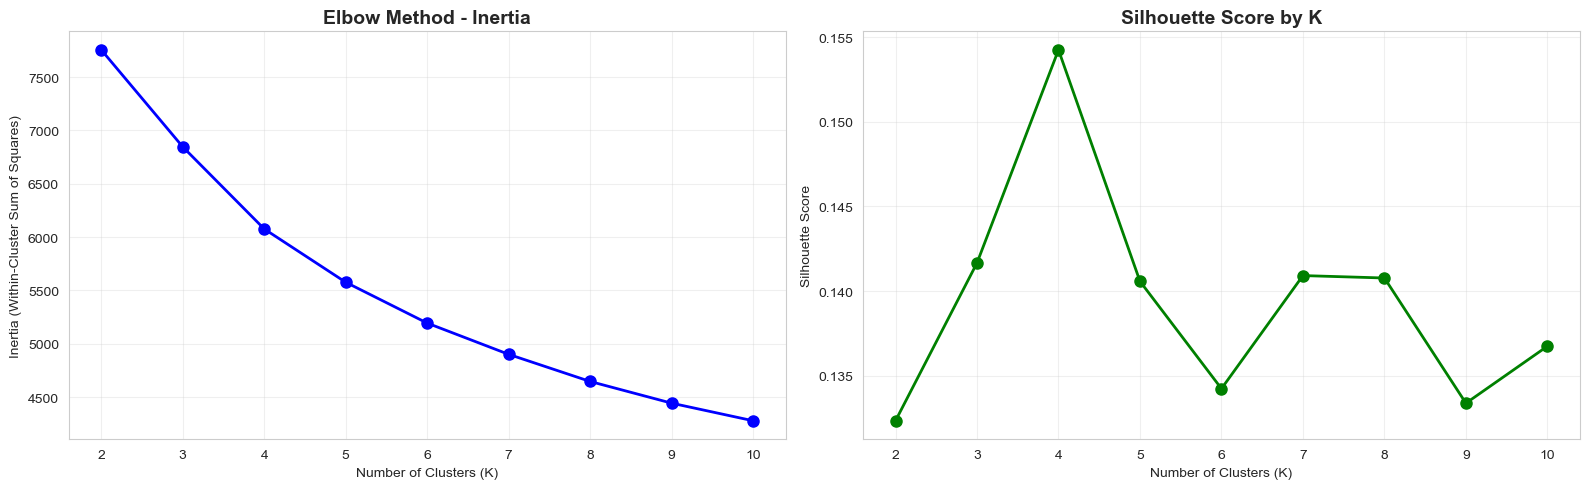

Optimal number of clusters: 4 (Silhouette Score: 0.154)
Total customers clustered: 1000

Cluster Distribution:
----------------------------------------------------------------------------------------------------
  Cluster 0: 459 customers (45.9%)
  Cluster 1: 38 customers (3.8%)
  Cluster 2: 251 customers (25.1%)
  Cluster 3: 252 customers (25.2%)


In [27]:
# To determine optimal number of clusters: 

# Prepare data for clustering
clustering_data = analysis_df[numerical_features].dropna()

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

# Elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

print("\nCalculating optimal clusters using Elbow Method")
from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))
    print(f"  K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette Score={silhouette_scores[-1]:.3f}")

# Visualization 7: Elbow Curve
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(K_range, inertias, marker='o', linewidth=2, markersize=8, color='blue')
axes[0].set_title('Elbow Method - Inertia', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)')
axes[0].grid(alpha=0.3)

axes[1].plot(K_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='green')
axes[1].set_title('Silhouette Score by K', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Select optimal K (highest silhouette score)
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k} (Silhouette Score: {max(silhouette_scores):.3f})")

# Applying k-means clustering

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to dataframe
analysis_df_clustered = analysis_df.loc[clustering_data.index].copy()
analysis_df_clustered['Cluster'] = cluster_labels

print(f"Total customers clustered: {len(cluster_labels)}")

# Cluster distribution
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print("\nCluster Distribution:")
print("-" * 100)
for cluster, count in cluster_counts.items():
    percentage = (count / len(cluster_labels)) * 100
    print(f"  Cluster {cluster}: {count} customers ({percentage:.1f}%)")

In [28]:
# Cluster Profiling 

# Calculate cluster centers in original scale
cluster_centers_scaled = kmeans.cluster_centers_
cluster_centers = scaler.inverse_transform(cluster_centers_scaled)

# Create cluster profile dataframe
cluster_profiles = pd.DataFrame(cluster_centers, columns=numerical_features)
cluster_profiles['Cluster'] = range(optimal_k)
cluster_profiles['Size'] = cluster_counts.values

print("\nCluster Profiles (Mean Values):")
display(cluster_profiles)

# Detailed statistics per cluster
print("\nDetailed Cluster Statistics:")
for cluster in range(optimal_k):
    print(f"\n{'='*50}")
    print(f"CLUSTER {cluster} - {cluster_counts[cluster]} customers ({cluster_counts[cluster]/len(cluster_labels)*100:.1f}%)")
    print(f"{'='*50}")
    
    cluster_data = analysis_df_clustered[analysis_df_clustered['Cluster'] == cluster]
    
    print(f"  Average Age: {cluster_data['Age'].mean():.1f} years")
    print(f"  Average Income: ${cluster_data['Income'].mean():,.2f}")
    print(f"  Average Spending Score: {cluster_data['Spending_Score'].mean():.1f}")
    print(f"  Average Purchase Frequency: {cluster_data['Purchase_Frequency'].mean():.1f}")
    print(f"  Average Last Purchase: ${cluster_data['Last_Purchase_Amount'].mean():.2f}")
    print(f"  Average Membership: {cluster_data['Membership_Years'].mean():.1f} years")
    
    # Top categories
    top_category = cluster_data['Preferred_Category'].mode()
    if len(top_category) > 0:
        print(f"  Top Category: {top_category.iloc[0]}")
    
    # Gender distribution
    gender_dist = cluster_data['Gender'].value_counts()
    print(f"  Gender Distribution: {gender_dist.to_dict()}")



Cluster Profiles (Mean Values):


,Age,Income,Spending_Score,Membership_Years,Purchase_Frequency,Last_Purchase_Amount,Purchase_per_Year,Spending_per_Purchase,Income_to_Spending_Ratio,Cluster,Size
0,42.919390,85082.416122,53.376906,7.368192,31.455338,445.930654,3.927103,14.372511,369.488412,0,459
1,47.157895,111283.921053,57.894737,5.631579,24.552632,25.555263,4.438597,2.313931,4857.438307,1,38
2,44.079681,87157.071713,49.258964,5.011952,9.211155,603.363506,1.861458,79.942274,208.932739,2,251
3,44.551587,92629.988095,46.115079,2.440476,35.369048,536.710952,11.300510,16.217864,326.059336,3,252



Detailed Cluster Statistics:

CLUSTER 0 - 459 customers (45.9%)
  Average Age: 42.9 years
  Average Income: $85,082.42
  Average Spending Score: 53.4
  Average Purchase Frequency: 31.5
  Average Last Purchase: $445.93
  Average Membership: 7.4 years
  Top Category: Electronics
  Gender Distribution: {'Male': 174, 'Female': 144, 'Other': 141}

CLUSTER 1 - 38 customers (3.8%)
  Average Age: 47.2 years
  Average Income: $111,283.92
  Average Spending Score: 57.9
  Average Purchase Frequency: 24.6
  Average Last Purchase: $25.56
  Average Membership: 5.6 years
  Top Category: Sports
  Gender Distribution: {'Male': 16, 'Other': 11, 'Female': 11}

CLUSTER 2 - 251 customers (25.1%)
  Average Age: 44.1 years
  Average Income: $87,157.07
  Average Spending Score: 49.3
  Average Purchase Frequency: 9.2
  Average Last Purchase: $603.36
  Average Membership: 5.0 years
  Top Category: Home & Garden
  Gender Distribution: {'Other': 91, 'Female': 85, 'Male': 75}

CLUSTER 3 - 252 customers (25.2%)
  

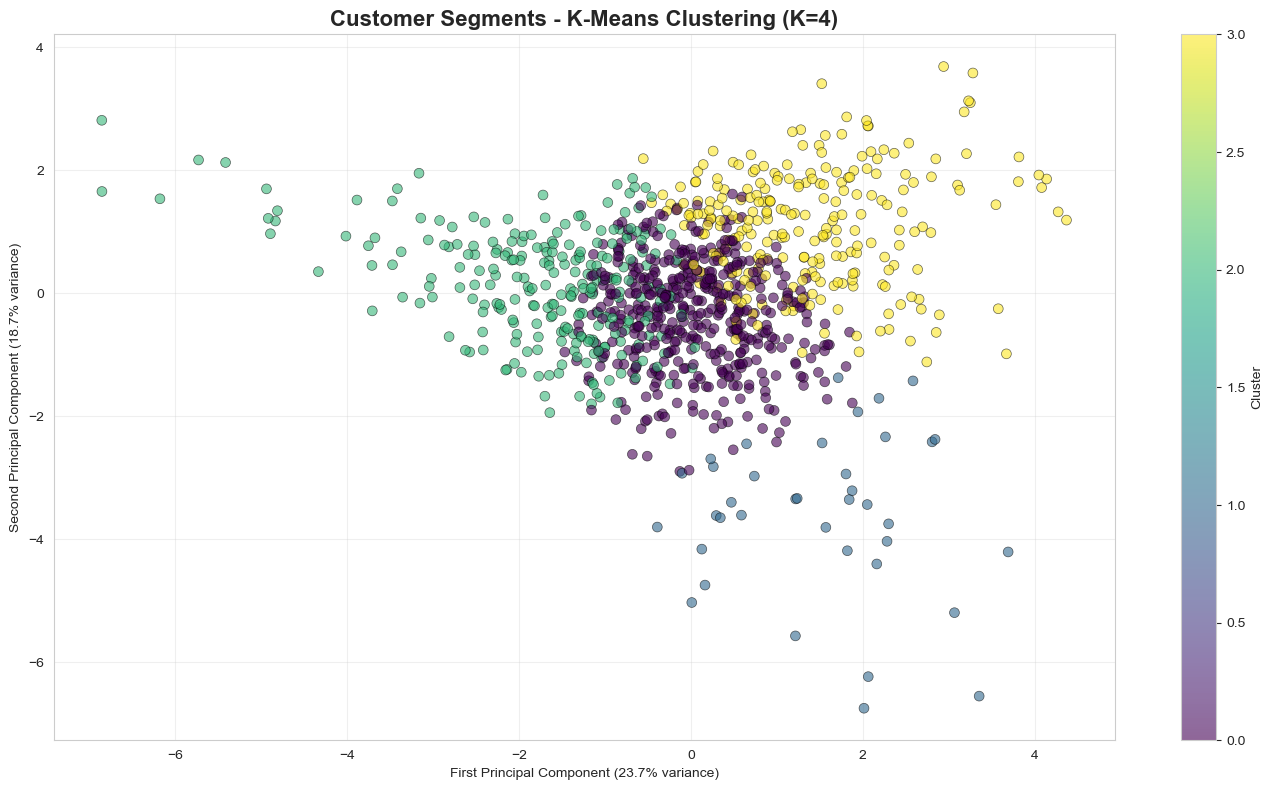

PCA explains 42.3% of variance


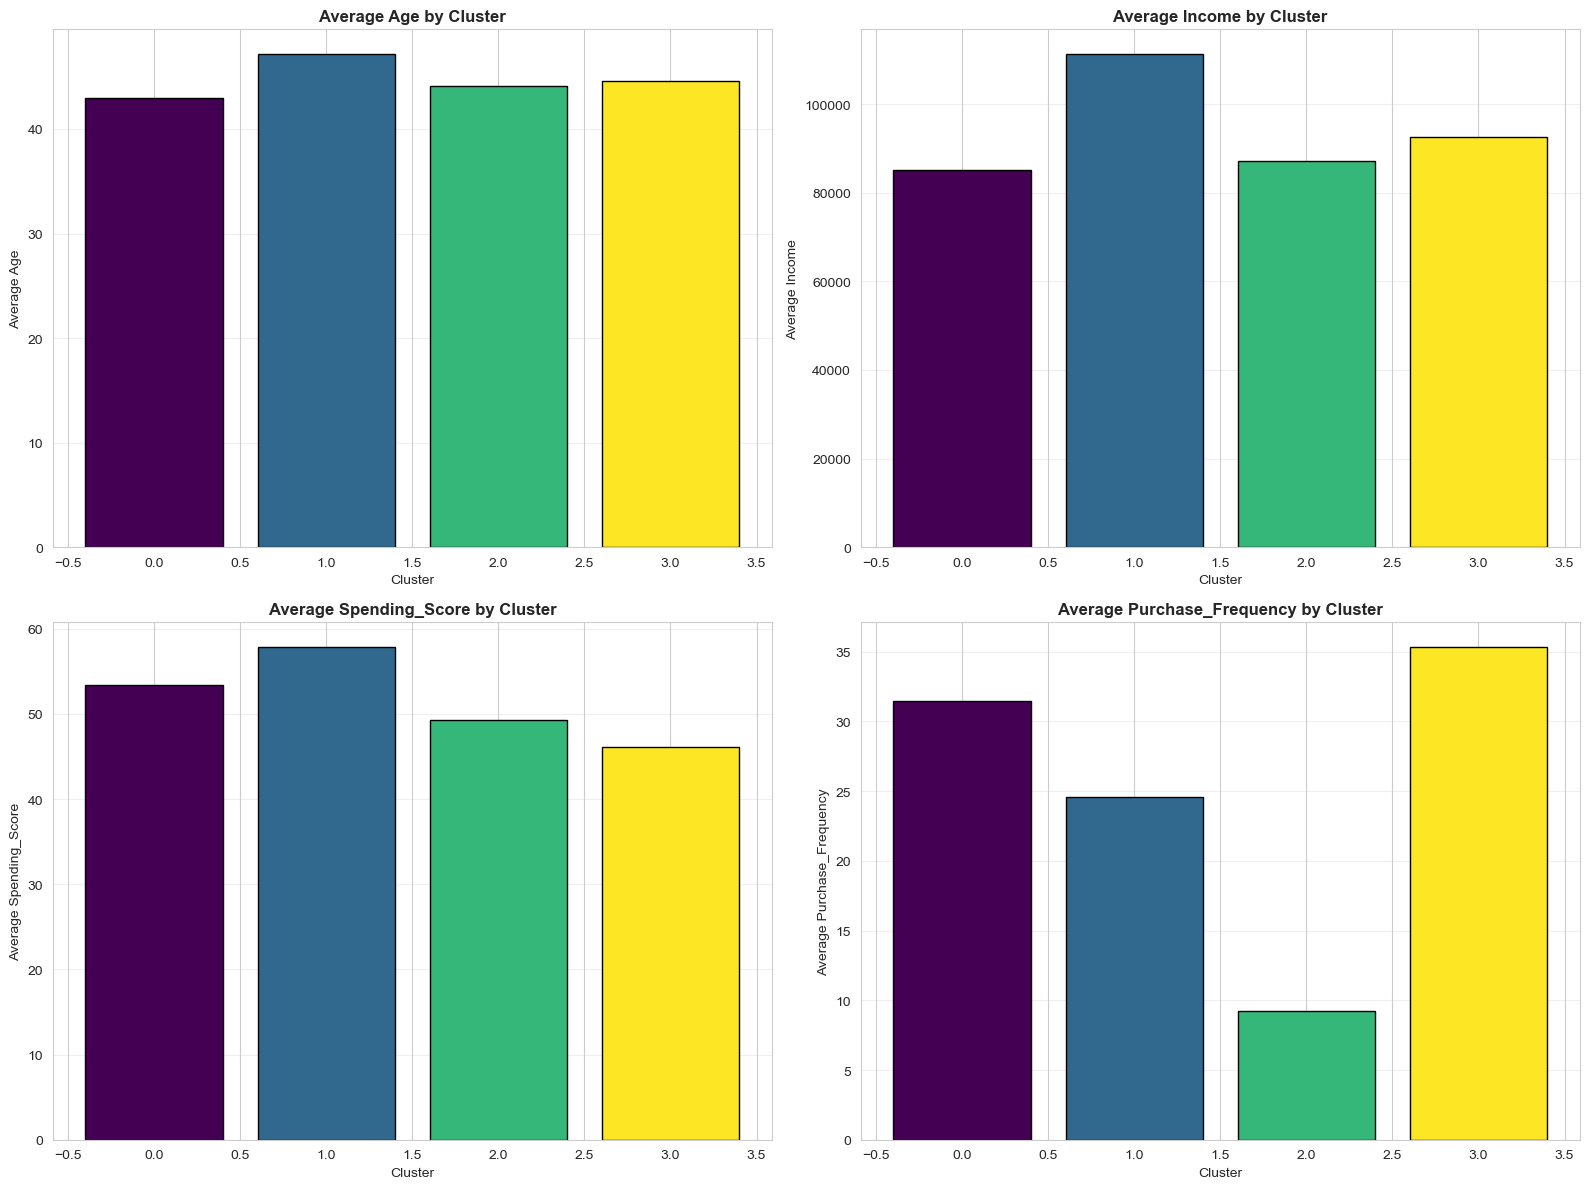

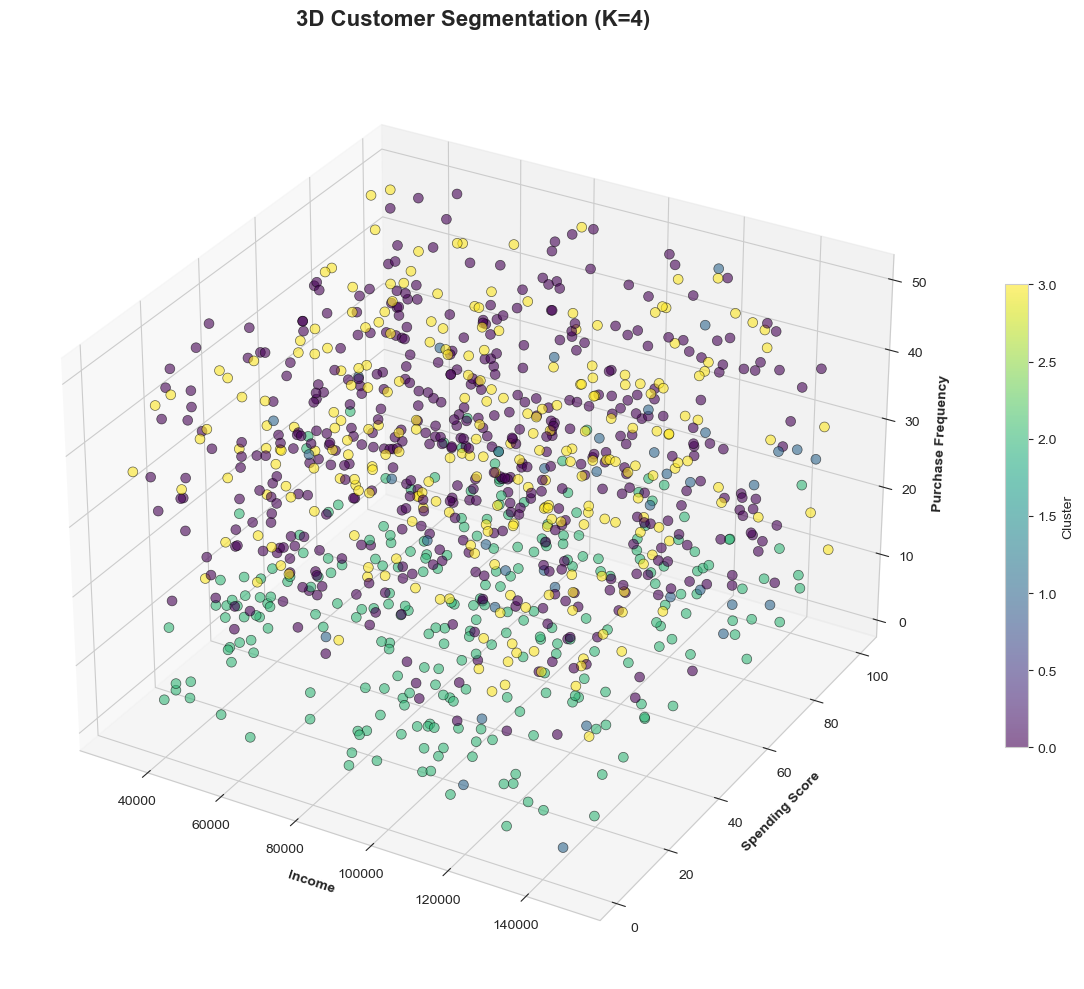

In [29]:
# Cluster Visualisations

# Visualization 8: PCA for 2D visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(14, 8))
scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels, 
                     cmap='viridis', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.title(f'Customer Segments - K-Means Clustering (K={optimal_k})', fontsize=16, fontweight='bold')
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"PCA explains {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100:.1f}% of variance")

# Visualization 9: Cluster comparison - Key metrics
key_metrics = ['Age', 'Income', 'Spending_Score', 'Purchase_Frequency']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, metric in enumerate(key_metrics):
    cluster_metric = analysis_df_clustered.groupby('Cluster')[metric].mean()
    axes[idx].bar(cluster_metric.index, cluster_metric.values, 
                  color=plt.cm.viridis(np.linspace(0, 1, optimal_k)), edgecolor='black')
    axes[idx].set_title(f'Average {metric} by Cluster', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel(f'Average {metric}')
    axes[idx].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Visualization 10: 3D Scatter (Income vs Spending Score vs Purchase Frequency)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(analysis_df_clustered['Income'], 
                    analysis_df_clustered['Spending_Score'],
                    analysis_df_clustered['Purchase_Frequency'],
                    c=cluster_labels, cmap='viridis', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

ax.set_xlabel('Income', fontweight='bold')
ax.set_ylabel('Spending Score', fontweight='bold')
ax.set_zlabel('Purchase Frequency', fontweight='bold')
ax.set_title(f'3D Customer Segmentation (K={optimal_k})', fontsize=16, fontweight='bold', pad=20)
plt.colorbar(scatter, label='Cluster', shrink=0.5)
plt.tight_layout()
plt.show()

In [30]:
# Feature selection for Predictive Modelling 

# Identifying top features based on correlation with key target variables
target_variables = ['Spending_Score', 'Last_Purchase_Amount', 'Purchase_Frequency']

print("\nTop Features for Each Target Variable:")
print("-" * 100)

selected_features = set()

for target in target_variables:
    if target in correlation_matrix.columns:
        correlations = correlation_matrix[target].abs().sort_values(ascending=False)
        correlations = correlations[correlations.index != target]  # Exclude self
        
        print(f"\n{target}:")
        top_5 = correlations.head(5)
        for feature, corr in top_5.items():
            print(f"  - {feature}: {corr:.3f}")
            selected_features.add(feature)

print(f"Total unique features identified: {len(selected_features)}")
print(f"Recommended features for predictive model:")
for i, feature in enumerate(sorted(selected_features), 1):
    print(f"  {i}. {feature}")



Top Features for Each Target Variable:
----------------------------------------------------------------------------------------------------

Spending_Score:
  - Income_to_Spending_Ratio: 0.048
  - Spending_per_Purchase: 0.034
  - Purchase_per_Year: 0.032
  - Membership_Years: 0.027
  - Age: 0.018

Last_Purchase_Amount:
  - Income_to_Spending_Ratio: 0.502
  - Spending_per_Purchase: 0.384
  - Age: 0.062
  - Income: 0.054
  - Purchase_Frequency: 0.024

Purchase_Frequency:
  - Purchase_per_Year: 0.605
  - Spending_per_Purchase: 0.537
  - Membership_Years: 0.070
  - Age: 0.030
  - Last_Purchase_Amount: 0.024
Total unique features identified: 8
Recommended features for predictive model:
  1. Age
  2. Income
  3. Income_to_Spending_Ratio
  4. Last_Purchase_Amount
  5. Membership_Years
  6. Purchase_Frequency
  7. Purchase_per_Year
  8. Spending_per_Purchase


In [31]:
# Saving results

# Save clustered data
output_path = r"C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\clustered_customer_data.csv"
analysis_df_clustered.to_csv(output_path, index=False)
print(f"Clustered data saved to: {output_path}")

# Save cluster profiles
profiles_path = r"C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\cluster_profiles.csv"
cluster_profiles.to_csv(profiles_path, index=False)
print(f"Cluster profiles saved to: {profiles_path}")

# Save correlation matrix
corr_path = r"C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\correlation_matrix.csv"
correlation_matrix.to_csv(corr_path)
print(f"Correlation matrix saved to: {corr_path}")


Clustered data saved to: C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\clustered_customer_data.csv
Cluster profiles saved to: C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\cluster_profiles.csv
Correlation matrix saved to: C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\correlation_matrix.csv


In [32]:
# Summary Report

print("\n" + "=" * 100)
print("Final Summary Report")
print("=" * 100)

print(f"""
Data Integration & Clustering Analysis - Summary
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

1. DATASETS INTEGRATED
   - Customer Behaviour Data
   - Customer Segmentation Data
   - Sales Data

2. CORRELATION ANALYSIS
   - Features Analyzed: {len(numerical_features)}
   - Strongest Correlation: {corr_df.iloc[0]['Correlation']:.3f} ({corr_df.iloc[0]['Feature 1']} ↔ {corr_df.iloc[0]['Feature 2']})

3. CLUSTERING RESULTS
   - Optimal Clusters: {optimal_k}
   - Silhouette Score: {max(silhouette_scores):.3f}
   - Total Customers Clustered: {len(cluster_labels):,}

4. KEY INSIGHTS
   - Largest Cluster: Cluster {cluster_counts.idxmax()} ({cluster_counts.max()} customers, {cluster_counts.max()/len(cluster_labels)*100:.1f}%)
   - Smallest Cluster: Cluster {cluster_counts.idxmin()} ({cluster_counts.min()} customers, {cluster_counts.min()/len(cluster_labels)*100:.1f}%)

5. RECOMMENDED FEATURES FOR PREDICTIVE MODEL
   {chr(10).join([f'   - {f}' for f in sorted(selected_features)])}
""")


Final Summary Report

Data Integration & Clustering Analysis - Summary
Generated: 2026-02-16 13:06:38

1. DATASETS INTEGRATED
   - Customer Behaviour Data
   - Customer Segmentation Data
   - Sales Data

2. CORRELATION ANALYSIS
   - Features Analyzed: 9
   - Strongest Correlation: 0.605 (Purchase_Frequency ↔ Purchase_per_Year)

3. CLUSTERING RESULTS
   - Optimal Clusters: 4
   - Silhouette Score: 0.154
   - Total Customers Clustered: 1,000

4. KEY INSIGHTS
   - Largest Cluster: Cluster 0 (459 customers, 45.9%)
   - Smallest Cluster: Cluster 1 (38 customers, 3.8%)

5. RECOMMENDED FEATURES FOR PREDICTIVE MODEL
      - Age
   - Income
   - Income_to_Spending_Ratio
   - Last_Purchase_Amount
   - Membership_Years
   - Purchase_Frequency
   - Purchase_per_Year
   - Spending_per_Purchase



In [33]:
# Enhanced Clustering Analysis - DBSCAN, Hierarchical & Cluster Naming

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Loading the previously clustered data
clustered_data_path = r"C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\clustered_customer_data.csv"
analysis_df = pd.read_csv(clustered_data_path)

print(f"Data loaded: {analysis_df.shape[0]} rows × {analysis_df.shape[1]} columns")

# Preparing features for clustering
numerical_features = ['Age', 'Income', 'Spending_Score', 'Membership_Years', 
                      'Purchase_Frequency', 'Last_Purchase_Amount',
                      'Purchase_per_Year', 'Spending_per_Purchase', 'Income_to_Spending_Ratio']

clustering_data = analysis_df[numerical_features].dropna()

# Standardizing features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

print(f"Features prepared: {len(numerical_features)} features")
print(f"Samples for clustering: {len(scaled_data)}")

# Using K-means clustering

# Using optimal K from previous analysis
optimal_k_kmeans = 4
kmeans = KMeans(n_clusters=optimal_k_kmeans, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(scaled_data)

# Calculating metrics
kmeans_silhouette = silhouette_score(scaled_data, kmeans_labels)
kmeans_davies_bouldin = davies_bouldin_score(scaled_data, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(scaled_data, kmeans_labels)

print(f"K-Means Clustering Complete (K={optimal_k_kmeans})")
print(f"  - Silhouette Score: {kmeans_silhouette:.4f}")
print(f"  - Davies-Bouldin Index: {kmeans_davies_bouldin:.4f} (lower is better)")
print(f"  - Calinski-Harabasz Score: {kmeans_calinski:.4f} (higher is better)")

cluster_counts_kmeans = pd.Series(kmeans_labels).value_counts().sort_index()
print(f"\nCluster Distribution:")
for cluster, count in cluster_counts_kmeans.items():
    print(f"  Cluster {cluster}: {count} customers ({count/len(kmeans_labels)*100:.1f}%)")

Data loaded: 1000 rows × 13 columns
Features prepared: 9 features
Samples for clustering: 1000
K-Means Clustering Complete (K=4)
  - Silhouette Score: 0.1542
  - Davies-Bouldin Index: 1.7477 (lower is better)
  - Calinski-Harabasz Score: 159.8174 (higher is better)

Cluster Distribution:
  Cluster 0: 459 customers (45.9%)
  Cluster 1: 38 customers (3.8%)
  Cluster 2: 251 customers (25.1%)
  Cluster 3: 252 customers (25.2%)


Creating dendrogram


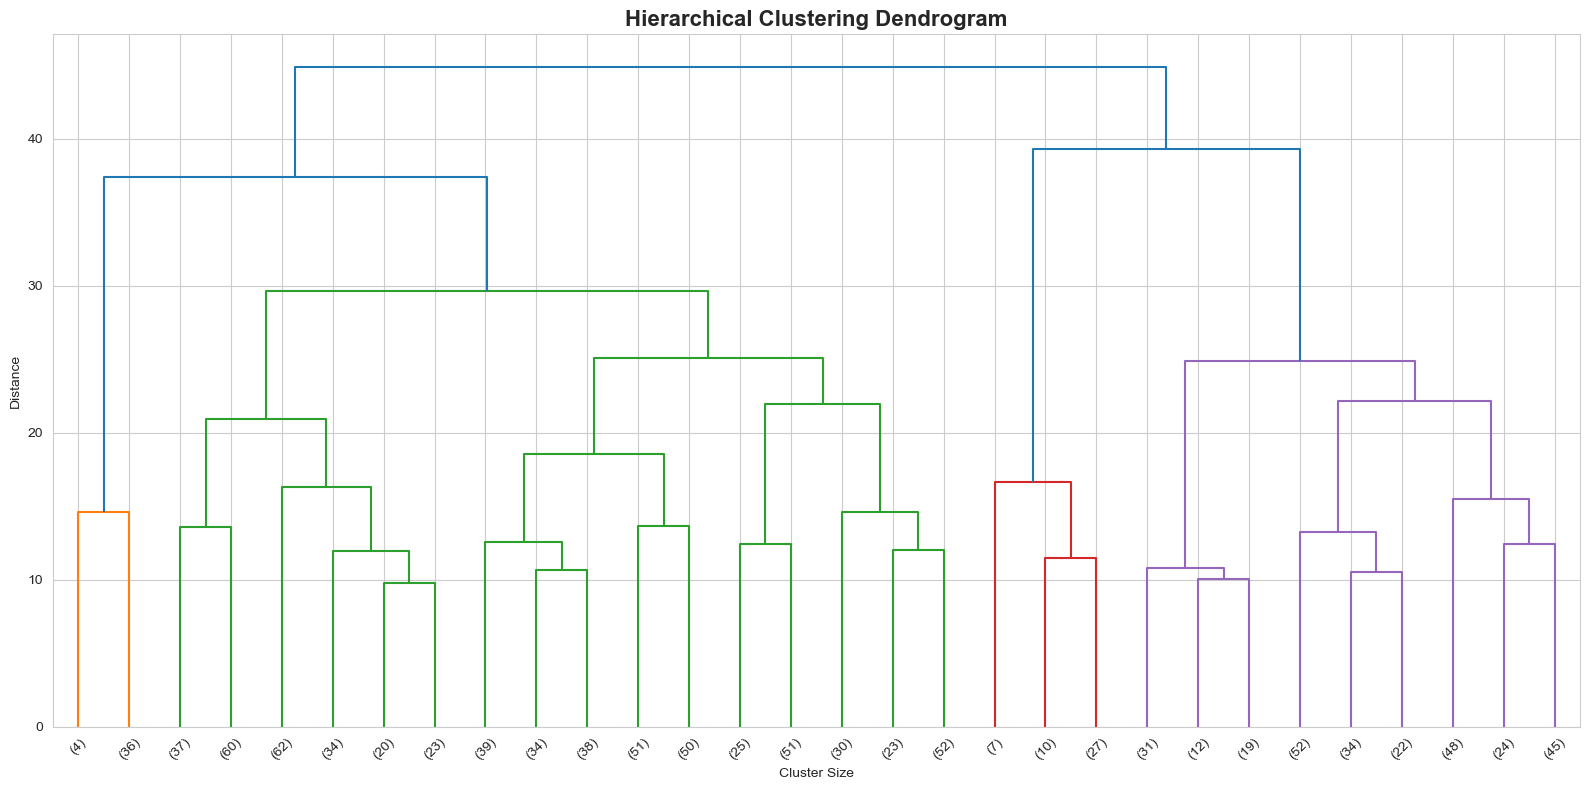

Testing different cluster numbers
  K=2: Silhouette=0.1322, DB=2.5302, CH=125.65
  K=3: Silhouette=0.1235, DB=1.9696, CH=122.73
  K=4: Silhouette=0.1335, DB=1.7881, CH=126.17
  K=5: Silhouette=0.1007, DB=1.9574, CH=119.39
  K=6: Silhouette=0.0943, DB=1.9390, CH=111.51
  K=7: Silhouette=0.0918, DB=1.9863, CH=107.49
Optimal K for Hierarchical: 4
  - Silhouette Score: 0.1335

Cluster Distribution:
  Cluster 0: 629 customers (62.9%)
  Cluster 1: 287 customers (28.7%)
  Cluster 2: 44 customers (4.4%)
  Cluster 3: 40 customers (4.0%)


In [34]:
# Hierarchal Clustering 

# Creating dendrogram to visualize hierarchy
print("Creating dendrogram")
plt.figure(figsize=(16, 8))
linkage_matrix = linkage(scaled_data, method='ward')
dendrogram(linkage_matrix, truncate_mode='lastp', p=30, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram', fontsize=16, fontweight='bold')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# Trying different numbers of clusters
hierarchical_results = {}
print("Testing different cluster numbers")

for n_clusters in range(2, 8):
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    hier_labels = hierarchical.fit_predict(scaled_data)
    
    silhouette = silhouette_score(scaled_data, hier_labels)
    davies_bouldin = davies_bouldin_score(scaled_data, hier_labels)
    calinski = calinski_harabasz_score(scaled_data, hier_labels)
    
    hierarchical_results[n_clusters] = {
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski': calinski,
        'labels': hier_labels
    }
    
    print(f"  K={n_clusters}: Silhouette={silhouette:.4f}, DB={davies_bouldin:.4f}, CH={calinski:.2f}")

# Selecting optimal K for hierarchical
optimal_k_hier = max(hierarchical_results.keys(), 
                     key=lambda k: hierarchical_results[k]['silhouette'])

hier_labels = hierarchical_results[optimal_k_hier]['labels']
hier_silhouette = hierarchical_results[optimal_k_hier]['silhouette']

print(f"Optimal K for Hierarchical: {optimal_k_hier}")
print(f"  - Silhouette Score: {hier_silhouette:.4f}")

cluster_counts_hier = pd.Series(hier_labels).value_counts().sort_index()
print(f"\nCluster Distribution:")
for cluster, count in cluster_counts_hier.items():
    print(f"  Cluster {cluster}: {count} customers ({count/len(hier_labels)*100:.1f}%)")

Finding optimal epsilon


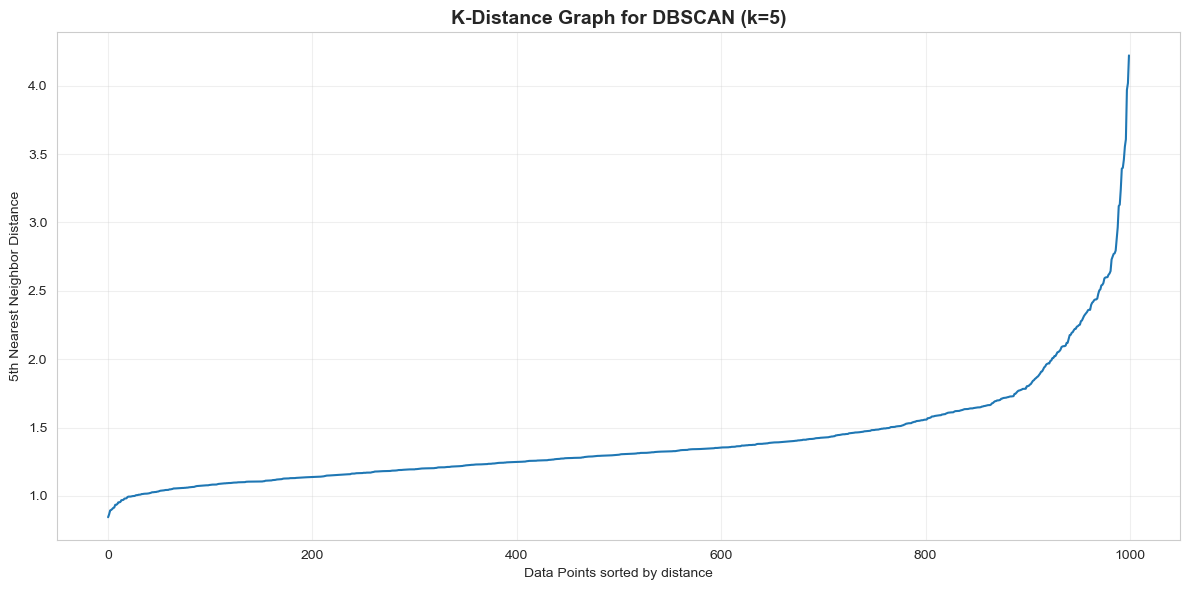

Testing different epsilon values
  eps=0.5: Clusters=0, Noise points=1000 (100.0%), Silhouette=-1.0000
  eps=1.0: Clusters=15, Noise points=898 (89.8%), Silhouette=0.3686
  eps=1.5: Clusters=1, Noise points=119 (11.9%), Silhouette=-1.0000
  eps=2.0: Clusters=1, Noise points=54 (5.4%), Silhouette=-1.0000
  eps=2.5: Clusters=1, Noise points=12 (1.2%), Silhouette=-1.0000
Selected eps=1.0
  - Number of Clusters: 15
  - Noise Points: 898 (89.8%)


In [35]:
# DBSCAN Clustering

# Find optimal epsilon using k-distance graph
from sklearn.neighbors import NearestNeighbors

print("Finding optimal epsilon")
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

distances = np.sort(distances[:, -1], axis=0)

plt.figure(figsize=(12, 6))
plt.plot(distances)
plt.title('K-Distance Graph for DBSCAN (k=5)', fontsize=14, fontweight='bold')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Try different epsilon values
print("Testing different epsilon values")
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5]
dbscan_results = {}

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(scaled_data)
    
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    
    if n_clusters > 1:
        # Only calculate silhouette if we have more than 1 cluster
        valid_labels = dbscan_labels[dbscan_labels != -1]
        valid_data = scaled_data[dbscan_labels != -1]
        
        if len(set(valid_labels)) > 1:
            silhouette = silhouette_score(valid_data, valid_labels)
        else:
            silhouette = -1
    else:
        silhouette = -1
    
    dbscan_results[eps] = {
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'silhouette': silhouette,
        'labels': dbscan_labels
    }
    
    print(f"  eps={eps}: Clusters={n_clusters}, Noise points={n_noise} ({n_noise/len(dbscan_labels)*100:.1f}%), Silhouette={silhouette:.4f}")

# Select best epsilon (highest silhouette with reasonable number of clusters)
best_eps = max([k for k in dbscan_results.keys() if dbscan_results[k]['silhouette'] > 0], 
               key=lambda k: dbscan_results[k]['silhouette'], default=1.5)

dbscan_labels = dbscan_results[best_eps]['labels']
dbscan_n_clusters = dbscan_results[best_eps]['n_clusters']
dbscan_n_noise = dbscan_results[best_eps]['n_noise']

print(f"Selected eps={best_eps}")
print(f"  - Number of Clusters: {dbscan_n_clusters}")
print(f"  - Noise Points: {dbscan_n_noise} ({dbscan_n_noise/len(dbscan_labels)*100:.1f}%)")


Clustering Performance Comparison:
----------------------------------------------------------------------------------------------------


,Method,Num_Clusters,Silhouette_Score,Davies_Bouldin,Noise_Points
0,K-Means,4,0.154242,1.747735,0
1,Hierarchical,4,0.133549,1.788061,0
2,DBSCAN,15,0.368594,N/A,898


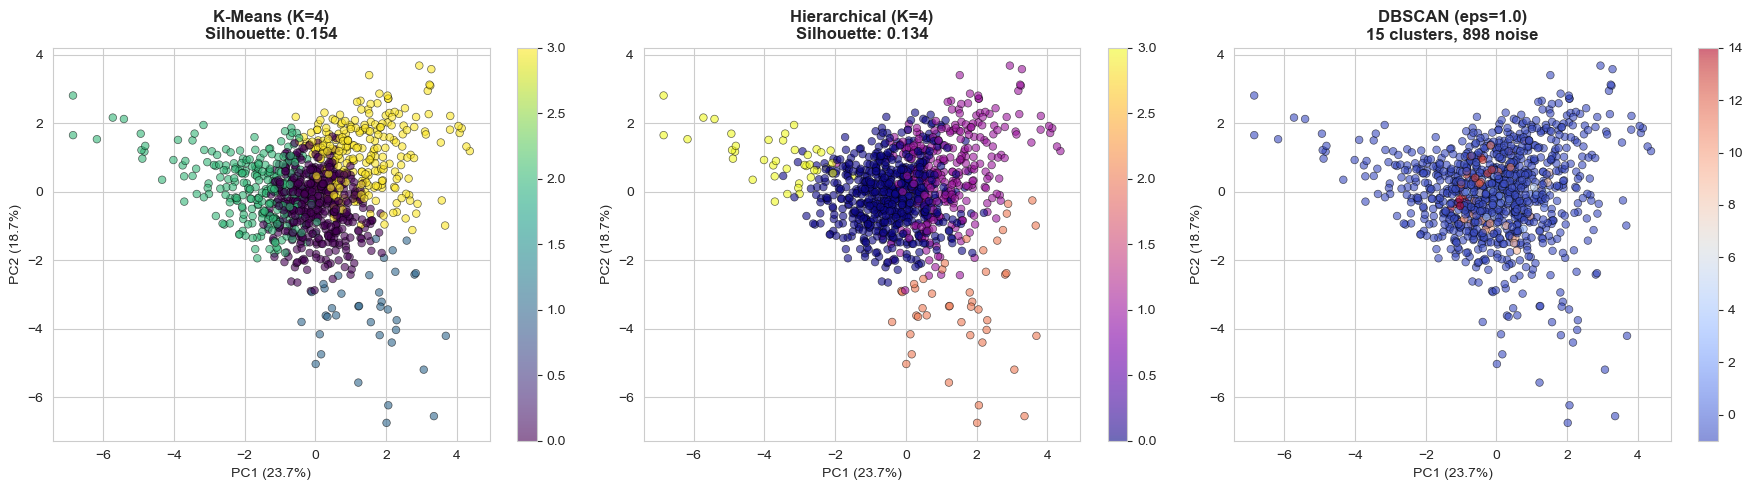

In [36]:
# Clustering Comparison 

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Method': ['K-Means', 'Hierarchical', 'DBSCAN'],
    'Num_Clusters': [optimal_k_kmeans, optimal_k_hier, dbscan_n_clusters],
    'Silhouette_Score': [kmeans_silhouette, hier_silhouette, 
                         dbscan_results[best_eps]['silhouette']],
    'Davies_Bouldin': [kmeans_davies_bouldin, 
                       hierarchical_results[optimal_k_hier]['davies_bouldin'],
                       'N/A'],
    'Noise_Points': [0, 0, dbscan_n_noise]
})

print("\nClustering Performance Comparison:")
print("-" * 100)
display(comparison_df)

# Visualization: Comparison of clustering methods
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Use PCA for 2D visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# K-Means
scatter1 = axes[0].scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_labels, 
                          cmap='viridis', alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
axes[0].set_title(f'K-Means (K={optimal_k_kmeans})\nSilhouette: {kmeans_silhouette:.3f}', 
                 fontsize=12, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.colorbar(scatter1, ax=axes[0])

# Hierarchical
scatter2 = axes[1].scatter(pca_data[:, 0], pca_data[:, 1], c=hier_labels, 
                          cmap='plasma', alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
axes[1].set_title(f'Hierarchical (K={optimal_k_hier})\nSilhouette: {hier_silhouette:.3f}', 
                 fontsize=12, fontweight='bold')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.colorbar(scatter2, ax=axes[1])

# DBSCAN
scatter3 = axes[2].scatter(pca_data[:, 0], pca_data[:, 1], c=dbscan_labels, 
                          cmap='coolwarm', alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
axes[2].set_title(f'DBSCAN (eps={best_eps})\n{dbscan_n_clusters} clusters, {dbscan_n_noise} noise', 
                 fontsize=12, fontweight='bold')
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.colorbar(scatter3, ax=axes[2])

plt.tight_layout()
plt.show()

In [37]:
# Intelligenct Cluster Naming and Profiling

# Add cluster labels to dataframe
analysis_df_clustered = analysis_df.loc[clustering_data.index].copy()
analysis_df_clustered['KMeans_Cluster'] = kmeans_labels
analysis_df_clustered['Hierarchical_Cluster'] = hier_labels
analysis_df_clustered['DBSCAN_Cluster'] = dbscan_labels

# Analyze each K-Means cluster to create meaningful names
cluster_profiles = []

for cluster in range(optimal_k_kmeans):
    cluster_data = analysis_df_clustered[analysis_df_clustered['KMeans_Cluster'] == cluster]
    
    profile = {
        'Cluster': cluster,
        'Size': len(cluster_data),
        'Avg_Age': cluster_data['Age'].mean(),
        'Avg_Income': cluster_data['Income'].mean(),
        'Avg_Spending_Score': cluster_data['Spending_Score'].mean(),
        'Avg_Purchase_Freq': cluster_data['Purchase_Frequency'].mean(),
        'Avg_Last_Purchase': cluster_data['Last_Purchase_Amount'].mean(),
        'Avg_Membership': cluster_data['Membership_Years'].mean()
    }
    cluster_profiles.append(profile)

cluster_profiles_df = pd.DataFrame(cluster_profiles)

print("\nCluster Profiles:")
print("-" * 100)
display(cluster_profiles_df)

# Create intelligent cluster names based on characteristics
def name_cluster(profile):
    """Generate meaningful cluster name based on profile"""
    
    income = profile['Avg_Income']
    spending_score = profile['Avg_Spending_Score']
    purchase_freq = profile['Avg_Purchase_Freq']
    last_purchase = profile['Avg_Last_Purchase']
    
    # Income tier
    if income > 100000:
        income_tier = "Premium"
    elif income > 70000:
        income_tier = "Mid-tier"
    else:
        income_tier = "Budget"
    
    # Spending behavior
    if spending_score > 70:
        spending_behavior = "High Spenders"
    elif spending_score > 40:
        spending_behavior = "Moderate Spenders"
    else:
        spending_behavior = "Low Spenders"
    
    # Purchase frequency
    if purchase_freq > 30:
        freq_label = "Frequent Buyers"
    elif purchase_freq > 20:
        freq_label = "Regular Customers"
    else:
        freq_label = "Occasional Shoppers"
    
    # Combined name logic
    if spending_score > 70 and income > 90000:
        return "VIP High-Value Customers"
    elif spending_score > 70 and purchase_freq > 25:
        return "Active Big Spenders"
    elif spending_score < 30 and income < 60000:
        return "Budget-Conscious Shoppers"
    elif purchase_freq > 30 and spending_score < 50:
        return "Frequent Value Seekers"
    elif income > 90000 and spending_score < 50:
        return "High-Income Low-Engagement"
    elif purchase_freq < 15 and spending_score > 50:
        return "🌟 Occasional Premium Buyers"
    else:
        return f"{income_tier} {spending_behavior}"

# Apply naming
cluster_profiles_df['Cluster_Name'] = cluster_profiles_df.apply(name_cluster, axis=1)

print("\n" + "=" * 100)
print("NAMED CUSTOMER SEGMENTS")
print("=" * 100)

for _, row in cluster_profiles_df.iterrows():
    print(f"\n{row['Cluster_Name']} (Cluster {int(row['Cluster'])})")
    print("-" * 80)
    print(f"  Size: {int(row['Size'])} customers ({row['Size']/len(analysis_df_clustered)*100:.1f}%)")
    print(f"  Average Age: {row['Avg_Age']:.1f} years")
    print(f"  Average Income: ${row['Avg_Income']:,.2f}")
    print(f"  Spending Score: {row['Avg_Spending_Score']:.1f}/100")
    print(f"  Purchase Frequency: {row['Avg_Purchase_Freq']:.1f} purchases")
    print(f"  Average Purchase Amount: ${row['Avg_Last_Purchase']:.2f}")
    print(f"  Membership Years: {row['Avg_Membership']:.1f} years")

# Add cluster names to main dataframe
cluster_name_map = dict(zip(cluster_profiles_df['Cluster'], cluster_profiles_df['Cluster_Name']))
analysis_df_clustered['Cluster_Name'] = analysis_df_clustered['KMeans_Cluster'].map(cluster_name_map)


Cluster Profiles:
----------------------------------------------------------------------------------------------------


,Cluster,Size,Avg_Age,Avg_Income,Avg_Spending_Score,Avg_Purchase_Freq,Avg_Last_Purchase,Avg_Membership
0,0,459,42.919390,85082.416122,53.376906,31.455338,445.930654,7.368192
1,1,38,47.157895,111283.921053,57.894737,24.552632,25.555263,5.631579
2,2,251,44.079681,87157.071713,49.258964,9.211155,603.363506,5.011952
3,3,252,44.551587,92629.988095,46.115079,35.369048,536.710952,2.440476



NAMED CUSTOMER SEGMENTS

Mid-tier Moderate Spenders (Cluster 0)
--------------------------------------------------------------------------------
  Size: 459 customers (45.9%)
  Average Age: 42.9 years
  Average Income: $85,082.42
  Spending Score: 53.4/100
  Purchase Frequency: 31.5 purchases
  Average Purchase Amount: $445.93
  Membership Years: 7.4 years

Premium Moderate Spenders (Cluster 1)
--------------------------------------------------------------------------------
  Size: 38 customers (3.8%)
  Average Age: 47.2 years
  Average Income: $111,283.92
  Spending Score: 57.9/100
  Purchase Frequency: 24.6 purchases
  Average Purchase Amount: $25.56
  Membership Years: 5.6 years

Mid-tier Moderate Spenders (Cluster 2)
--------------------------------------------------------------------------------
  Size: 251 customers (25.1%)
  Average Age: 44.1 years
  Average Income: $87,157.07
  Spending Score: 49.3/100
  Purchase Frequency: 9.2 purchases
  Average Purchase Amount: $603.36
  Me

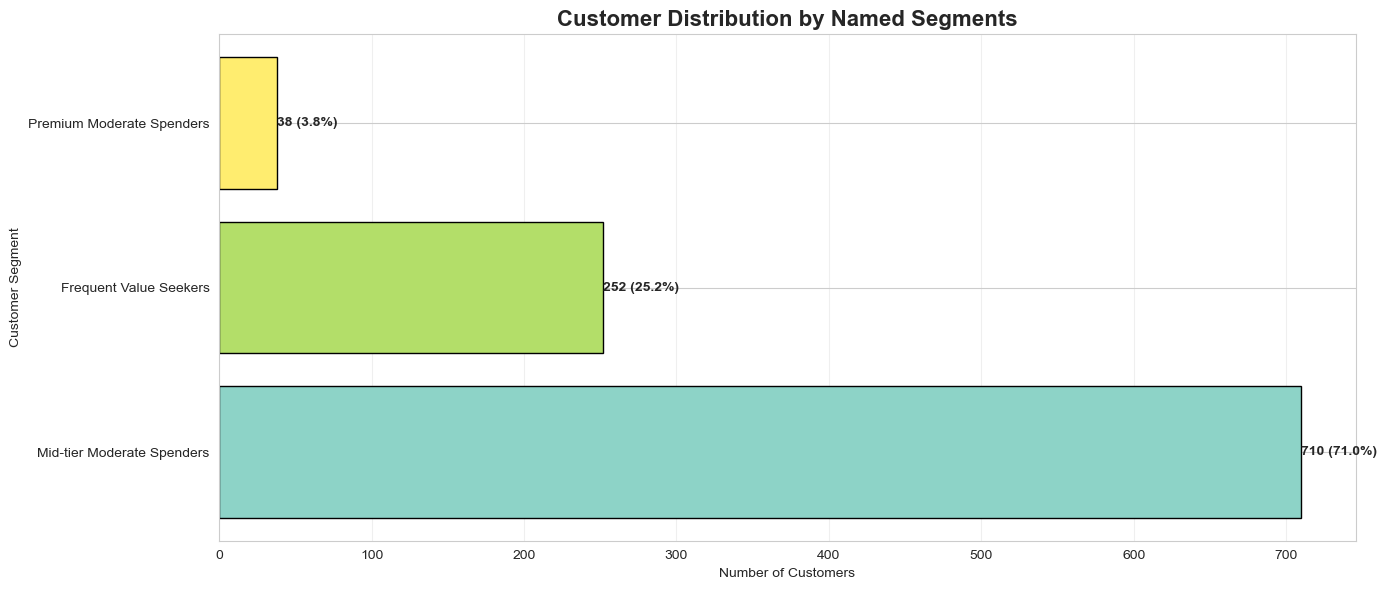

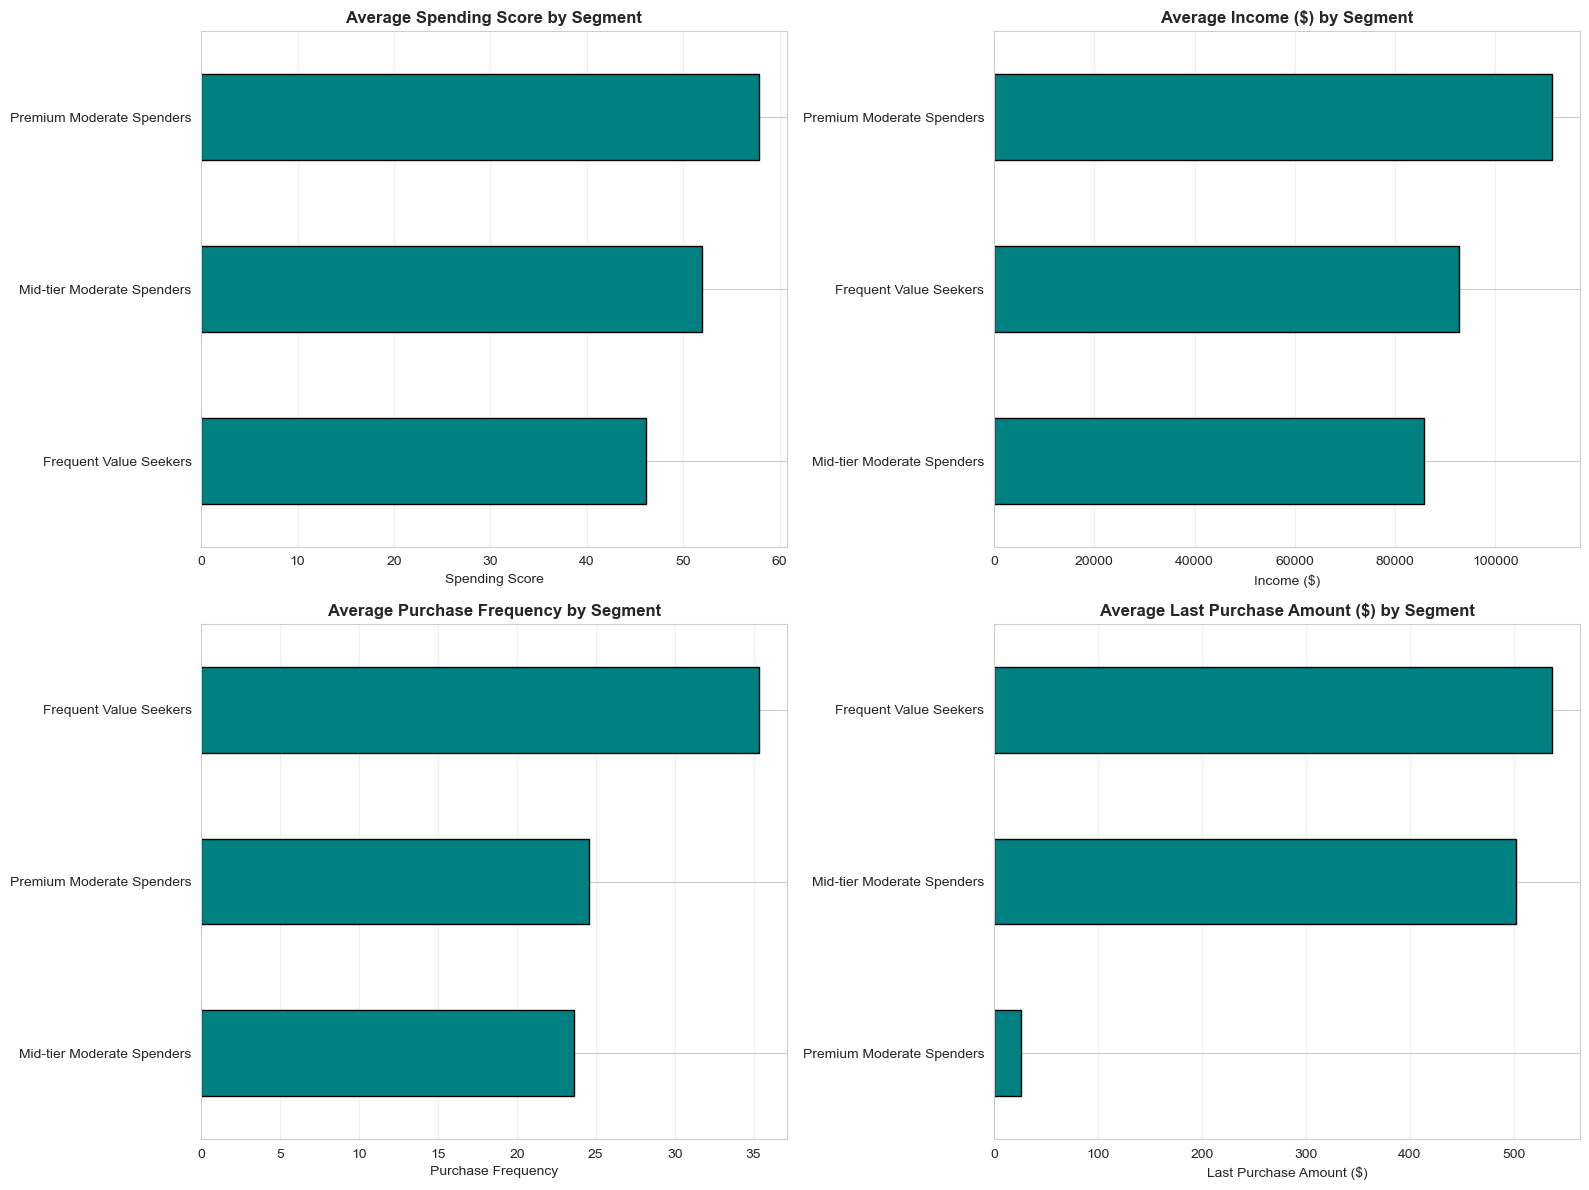

In [38]:
# Visualization - Named Clusters

# Visualization: Cluster size distribution with names
plt.figure(figsize=(14, 6))
cluster_sizes = analysis_df_clustered['Cluster_Name'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(cluster_sizes)))
bars = plt.barh(cluster_sizes.index, cluster_sizes.values, color=colors, edgecolor='black')
plt.title('Customer Distribution by Named Segments', fontsize=16, fontweight='bold')
plt.xlabel('Number of Customers')
plt.ylabel('Customer Segment')
plt.grid(alpha=0.3, axis='x')

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
            f'{int(width)} ({width/len(analysis_df_clustered)*100:.1f}%)',
            ha='left', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Visualization: Segment comparison by key metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = [
    ('Spending_Score', 'Spending Score'),
    ('Income', 'Income ($)'),
    ('Purchase_Frequency', 'Purchase Frequency'),
    ('Last_Purchase_Amount', 'Last Purchase Amount ($)')
]

for idx, (metric, label) in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    segment_metric = analysis_df_clustered.groupby('Cluster_Name')[metric].mean().sort_values()
    
    segment_metric.plot(kind='barh', ax=ax, color='teal', edgecolor='black')
    ax.set_title(f'Average {label} by Segment', fontsize=12, fontweight='bold')
    ax.set_xlabel(label)
    ax.set_ylabel('')
    ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


In [39]:
# Saving results

# Save enhanced clustered data with all clustering methods
output_path = r"C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\enhanced_clustered_data.csv"
analysis_df_clustered.to_csv(output_path, index=False)
print(f"Enhanced clustered data saved to: {output_path}")

# Save cluster profiles with names
profiles_path = r"C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\named_cluster_profiles.csv"
cluster_profiles_df.to_csv(profiles_path, index=False)
print(f"Named cluster profiles saved to: {profiles_path}")

# Save comparison results
comparison_path = r"C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\clustering_comparison.csv"
comparison_df.to_csv(comparison_path, index=False)
print(f"Clustering comparison saved to: {comparison_path}")

Enhanced clustered data saved to: C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\enhanced_clustered_data.csv
Named cluster profiles saved to: C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\named_cluster_profiles.csv
Clustering comparison saved to: C:\Users\Ahana\Desktop\Customer-Sales-Analysis\results\clustering_comparison.csv
